<a href="https://colab.research.google.com/github/Rama389/AI-Projects/blob/main/Deep_Learning_SPAM_text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Pre-Processing

## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
)

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Importing Dataset

In [ ]:
df = pd.read_csv("SPAM text message 20170820 - Data.csv", encoding="latin-1")
df = df.rename(columns={"Category": "label", "Message": "text"})

## Encoding the data

In [ ]:
le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])

X = df["text"].values
y = df["label"].values

## Test Train Split

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Tokenization & Padding
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len, padding="post")
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len, padding="post")

# Model Building

In [ ]:
def build_rnn(model_type="LSTM", embedding_dim=64, units=64, dropout=0.3):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=embedding_dim))

    if model_type == "LSTM":
        model.add(LSTM(units, dropout=dropout, recurrent_dropout=0.2))
    else:
        model.add(GRU(units, dropout=dropout, recurrent_dropout=0.2))

    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

#Evaluate Model

In [ ]:
def train_and_evaluate(model_type, embedding_dim, units, dropout):
    checkpoint_path = f"best_{model_type}_{embedding_dim}_{units}_{dropout}.keras"

    model = build_rnn(model_type, embedding_dim, units, dropout)

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        ModelCheckpoint(filepath=checkpoint_path, monitor="val_loss", save_best_only=True)
    ]

    history = model.fit(
        X_train_pad, y_train,
        validation_split=0.2,
        epochs=10,
        batch_size=64,
        callbacks=callbacks,
        verbose=0
    )

    # Evaluate
    y_pred_probs = model.predict(X_test_pad, verbose=0)
    y_pred = (y_pred_probs >= 0.5).astype(int)

    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return {
        "model_type": model_type,
        "embedding_dim": embedding_dim,
        "units": units,
        "dropout": dropout,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "checkpoint": checkpoint_path
    }

#Hyperparameter Tuning

In [ ]:
import random
import pandas as pd
param_space = {
    "model_type": ["LSTM", "GRU"],
    "embedding_dim": [32, 64],
    "units": [32, 64, 128],
    "dropout": [0.2, 0.3, 0.5],
}

# Sample random parameter combinations
def sample_params(param_space, n_samples=6):
    all_params = []
    for model_type in param_space["model_type"]:
        for embedding_dim in param_space["embedding_dim"]:
            for units in param_space["units"]:
                for dropout in param_space["dropout"]:
                    all_params.append({
                        "model_type": model_type,
                        "embedding_dim": embedding_dim,
                        "units": units,
                        "dropout": dropout
                    })
    return random.sample(all_params, n_samples)

random_combos = sample_params(param_space, n_samples=6)

results = []
for params in random_combos:
    print(f"Training {params['model_type']} | Embedding={params['embedding_dim']} | Units={params['units']} | Dropout={params['dropout']}")
    res = train_and_evaluate(
        params["model_type"],
        params["embedding_dim"],
        params["units"],
        params["dropout"]
    )
    results.append(res)

results_df = pd.DataFrame(results)
print("\nRandom Search Results:\n", results_df)


Training GRU | Embedding=32 | Units=32 | Dropout=0.2


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training LSTM | Embedding=32 | Units=128 | Dropout=0.2


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training GRU | Embedding=32 | Units=64 | Dropout=0.5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training GRU | Embedding=32 | Units=32 | Dropout=0.5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training LSTM | Embedding=32 | Units=64 | Dropout=0.5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training GRU | Embedding=64 | Units=128 | Dropout=0.3

Random Search Results:
   model_type  embedding_dim  units  dropout  accuracy  precision  recall   f1  \
0        GRU             32     32      0.2  0.866368        0.0     0.0  0.0   
1       LSTM             32    128      0.2  0.866368        0.0     0.0  0.0   
2        GRU             32     64      0.5  0.866368        0.0     0.0  0.0   
3        GRU             32     32      0.5  0.866368        0.0     0.0  0.0   
4       LSTM             32     64      0.5  0.866368        0.0     0.0  0.0   
5        GRU             64    128      0.3  0.866368        0.0     0.0  0.0   

                   checkpoint  
0    best_GRU_32_32_0.2.keras  
1  best_LSTM_32_128_0.2.keras  
2    best_GRU_32_64_0.5.keras  
3    best_GRU_32_32_0.5.keras  
4   best_LSTM_32_64_0.5.keras  
5   best_GRU_64_128_0.3.keras  


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#Classification Report

In [ ]:
final_model = build_rnn(
    str(best_model["model_type"]),
    int(best_model["embedding_dim"]),
    int(best_model["units"]),
    float(best_model["dropout"])
)

# Build the model by calling it on dummy input
final_model(np.zeros((1, max_len), dtype="int32"))

# Now load weights
final_model.load_weights(best_model["checkpoint"])

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


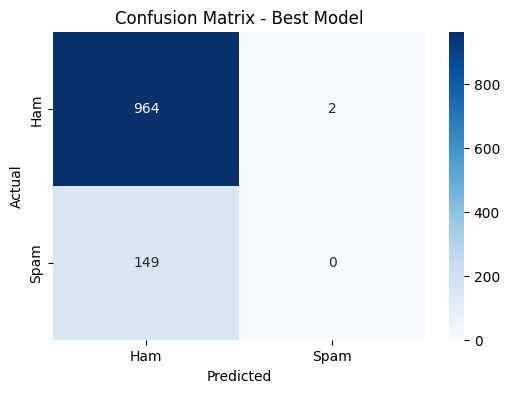


Classification Report:
               precision    recall  f1-score   support

         Ham       0.87      1.00      0.93       966
        Spam       0.00      0.00      0.00       149

    accuracy                           0.86      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.86      0.80      1115



In [ ]:

# Predictions
y_pred_probs = final_model.predict(X_test_pad, verbose=0)
y_pred = (y_pred_probs >= 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Ham","Spam"], yticklabels=["Ham","Spam"])
plt.title("Confusion Matrix - Best Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Ham","Spam"]))


The zero precision, recall and F1 score represents there is class imbalance. To avoid the class imbalance SMOTE is applied which is the best solution for class imbalance.

##Applying SMOTE for class balancing

Before SMOTE: [3859  598]
After SMOTE: [3859 3859]


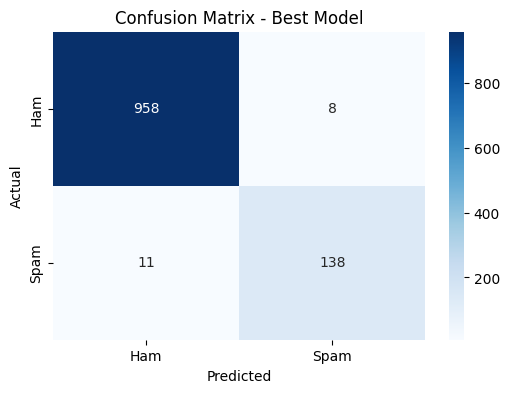


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.95      0.93      0.94       149

    accuracy                           0.98      1115
   macro avg       0.97      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115


Confusion Matrix:
 [[958   8]
 [ 11 138]]


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np

# 1. Convert text to numeric features (TF-IDF for SMOTE)
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['text']).toarray() # Corrected column name from 'message' to 'text'
y = df['label'].values # 'label' is already encoded in cell VpFbT2SQrDA0

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_res))

# 4. Train your model (can be LSTM/GRU but with embeddings you skip SMOTE, see note below)
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_res, y_train_res)

# 5. Evaluate
from sklearn.metrics import classification_report, confusion_matrix
y_pred = clf.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Ham","Spam"], yticklabels=["Ham","Spam"])
plt.title("Confusion Matrix - Best Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

The above confusion matrix is a good representation of the model. Precision, Recall and F1 score are in the range of 95%.